#### General Notes
- `airline_sentiment` and possibly `airline_sentiment_confidence` are target columns (the latter cannot be in training data)
- Remove instances of `"@airline"` tags from text

#### How to handle each column
**Numerical Columns**
- `negativereason_confidence` -- fill missing data with 0
- `retweet_count` -- remove, almost 100% is just 0

**Categorical Columns**
- `negativereason` -- one-hot encode top K reasons +1 column for "other"
- `airline` -- remove or one-hot encode with "other" column
- `airline_sentiment_gold` -- remove, almost 100% missing data
- `name` -- remove, unique data
- `negative_reason_gold` -- remove, almost 100% missing data
- `tweet_location` -- remove or one-hot encode with "other" column

**Other Columns**
- `tweet_coord` -- remove, almost 100% missing data
- `user_timezone` -- remove, a lot of missing and correlates with location
- `tweet_created` -- convert to columns: day of year (sin/cos), day of week, time of day (sin/cos)
- `text` -- sklearn.feature_extraction.text -> CountVectorizer (?)


### **Libraries and helper functions**

In [3]:
# Add parent directory to system path for module imports
import sys
sys.path.append('..')

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from src.transformers import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jasie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jasie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jasie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
# Import classifiers and label encoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder

In [6]:
# Importing features for model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Function to load and split the data
def load_data():
    df = pd.read_csv('../data/Tweets.csv')
    df = df.drop(columns=['tweet_id'])
    df_train, df_test = train_test_split(df, test_size=0.1, stratify=df[['airline_sentiment']], random_state=0)

    X_train = df_train.drop(columns=['airline_sentiment', 'airline_sentiment_confidence'])
    y_train = df_train[['airline_sentiment']]

    X_test = df_test.drop(columns=['airline_sentiment', 'airline_sentiment_confidence'])
    y_test = df_test[['airline_sentiment']]

    return X_train, y_train, X_test, y_test

### **Pipeline**

In [8]:
# Define columns for different preprocessing steps
columns_to_drop = ['retweet_count', 'airline_sentiment_gold', 'negativereason_gold', 'tweet_coord', 
                   'name', 'user_timezone', 'negativereason', 'negativereason_confidence']
columns_to_fill_zero = []
columns_to_fill_unknown = ['tweet_location']
columns_to_ohe = ['airline', 'tweet_location']


# Define the order of columns after transformation
column_order_after_transform = \
    columns_to_fill_zero + columns_to_fill_unknown + ['airline', 'text', 'tweet_created']
column_idx = lambda c: column_order_after_transform.index(c)

# Create a preprocessing pipeline
preprocessor = Pipeline(steps=[
    # Step 1: Drop unnecessary columns
    ('drop', DropColumnTransformer(columns_to_drop)),
    # Step 2: Fill missing values
    ('fill_missing',
        ColumnTransformer(
            transformers=[
                ('fill_zero', SimpleImputer(strategy='constant', fill_value=0), columns_to_fill_zero),
                ('fill_other', SimpleImputer(strategy='constant', fill_value='Unknown'), columns_to_fill_unknown),
            ],
            remainder='passthrough')),
    # Step 3: Encode categorical variables and transform other features
    ('encode', ColumnTransformer(transformers=[
        ('ohe', OneHotEncoder(
            handle_unknown='infrequent_if_exist',
            max_categories=10,
            sparse_output=False),
            list(map(column_idx, columns_to_ohe))),
        ('time', TimeTransformer(), list(map(column_idx, ['tweet_created']))),
        ('text', TextTransformer(), list(map(column_idx, ['text'])))
    ],
    remainder='passthrough'))
])

### **Data preparation**

In [9]:
# Load the data
X_train, y_train, X_test, y_test = load_data()

# Apply preprocessing to the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Encode target labels
le = LabelEncoder()
y_train_processed = le.fit_transform(y_train)
y_test_processed = le.transform(y_test)

C:\Users\jasie\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jasie\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


### **Classifiers**

Accuracy on training data: 0.7564
Accuracy on test data: 0.7295

Classification report for the test data:
              precision    recall  f1-score   support

    negative       0.77      0.90      0.83       918
     neutral       0.55      0.40      0.46       310
    positive       0.70      0.49      0.58       236

    accuracy                           0.73      1464
   macro avg       0.67      0.60      0.62      1464
weighted avg       0.71      0.73      0.71      1464



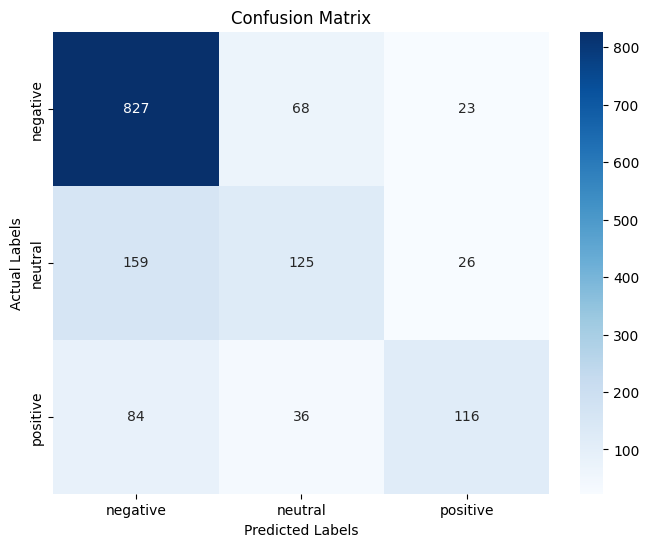

AUC (One-vs-Rest) on test data: 0.8431


0.7131776309279598

In [12]:
# Initializing the classifier (XGBClassifier(n_estimators=100) || LogisticRegression(max_iter=1000))
clf = LogisticRegression(max_iter=1000)

# Training the classifier on preprocessed training data
clf.fit(X_train_processed, y_train_processed)

# Predicting on the training data
y_train_pred = clf.predict(X_train_processed)

# Calculating accuracy on the training data
train_accuracy = accuracy_score(y_train_processed, y_train_pred)
print(f"Accuracy on training data: {train_accuracy:.4f}")

# Predicting on the test data
y_test_pred = clf.predict(X_test_processed)

# Calculating accuracy on the test data
test_accuracy = accuracy_score(y_test_processed, y_test_pred)
print(f"Accuracy on test data: {test_accuracy:.4f}")

# Generating a classification report
print("\nClassification report for the test data:")
print(classification_report(y_test_processed, y_test_pred, target_names=le.classes_))

# Generating a confusion matrix
cm = confusion_matrix(y_test_processed, y_test_pred)

# Visualizing the confusion matrix using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculating AUC for multi-class classification
y_test_prob = clf.predict_proba(X_test_processed)

auc = roc_auc_score(y_test_processed, y_test_prob, multi_class='ovr')
print(f"AUC (One-vs-Rest) on test data: {auc:.4f}")

test_f1 = f1_score(y_test_processed, y_test_pred, average='weighted')
test_f1
